In [1]:
%matplotlib inline
import re
import nltk
import gensim
import pickle
import pandas as pd
import numpy as np
import pyLDAvis.gensim
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from gensim import corpora
from sklearn.feature_extraction.text import TfidfTransformer

c:\users\garvi\appdata\local\programs\python\python36\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
df = pd.read_excel('WebTMA WOs Now.xlsx')

In [3]:
len(df)

268526

In [4]:
list(df)

['Work Order',
 'WO Type',
 'Charge Type',
 'Reference Number',
 'Project',
 'Action Requested',
 'Priority',
 'Status',
 'Requestor',
 'Req Phone',
 'Department',
 'Dept Number',
 'Account Number(s)',
 'Campus',
 'Building',
 'Floor',
 'Area',
 'Area Function',
 'Area Type',
 'Object Type',
 'WO Object',
 'Date Requested',
 'Date Estimate Began',
 'Date Estimate Was Completed',
 'Days to Estimate Completed',
 'Date WO Issued',
 'Days to Issue',
 'Scheduled Start Date',
 'Date Funded',
 'Funded Amount',
 'First Charge',
 'Days to Start',
 'Scheduled Completion Date',
 'Date Finished',
 'Days to Finish',
 'Date Completed',
 'Days to Completion',
 'Labor Hours',
 'FM Labor',
 'Flat Bill',
 'Warehouse Parts',
 'NonStock Received and Invoiced',
 'NonStock Received Not Invoiced',
 'NonStock On Order Not Received',
 'Total',
 'Assigned Trades',
 'General Comments',
 'Task Comments']

In [5]:
df.head()

,Work Order,WO Type,Charge Type,Reference Number,Project,Action Requested,Priority,Status,Requestor,Req Phone,...,FM Labor,Flat Bill,Warehouse Parts,NonStock Received and Invoiced,NonStock Received Not Invoiced,NonStock On Order Not Received,Total,Assigned Trades,General Comments,Task Comments
0,WEST-111249,3 PM,NaN,NaN,NaN,Zones Maintenance-Weekly,4 - 4 - Scheduled,Created By PM Schedule,PM Scheduler,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WMG1,NaN,NaN
1,WEST-111248,3 PM,NaN,NaN,NaN,Zones Maintenance-Weekly,4 - 4 - Scheduled,Created By PM Schedule,PM Scheduler,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WMG1,NaN,NaN
2,WEST-111247,3 PM,NaN,NaN,NaN,Zones Maintenance-Weekly,4 - 4 - Scheduled,Created By PM Schedule,PM Scheduler,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WMG1,NaN,NaN
3,WEST-111246,3 PM,NaN,NaN,NaN,Zones Maintenance-Weekly,4 - 4 - Scheduled,Created By PM Schedule,PM Scheduler,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WMG1,NaN,NaN
4,WEST-111245,3 PM,NaN,NaN,NaN,Zones Maintenance-Weekly,4 - 4 - Scheduled,Created By PM Schedule,PM Scheduler,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WMG1,NaN,NaN


In [6]:
def combine_columns(df,cols):
    all_docs = []
    for index, row in df.iterrows():
        tempstr = ''
        for col in cols:
            tempstr += str(row[col]) + ' '
        all_docs.append(tempstr)
    return all_docs        

In [7]:
all_docs = combine_columns(df,['Action Requested','General Comments','Task Comments'])

In [8]:
all_docs[0:5]

['Zones Maintenance-Weekly nan nan ',
 'Zones Maintenance-Weekly nan nan ',
 'Zones Maintenance-Weekly nan nan ',
 'Zones Maintenance-Weekly nan nan ',
 'Zones Maintenance-Weekly nan nan ']

In [9]:
def remove_punctutation(all_docs):
    no_punctuation_docs = []
    for doc in all_docs:
        doc = doc.replace("-", " ")
        no_punctuation_docs.append(re.sub(r'[^\w\s]','',doc))
    return no_punctuation_docs

In [10]:
def tokenizer(all_docs):
    tokenized_docs = []
    for doc in all_docs:
        tokenized_docs.append(word_tokenize(doc))
    return tokenized_docs

In [11]:
def lemmatizer(all_docs):
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized_docs = []
    for doc in all_docs:
        temp = []
        for token in doc:
            if token.isalpha():
                temp.append(wordnet_lemmatizer.lemmatize(token,"v"))
        lemmatized_docs.append(temp)
    return lemmatized_docs

In [12]:
def stemmer(all_docs):
    porter_stemmer = PorterStemmer()
    stemmed_docs = []
    for doc in all_docs:
        temp = []
        for token in doc:
            temp.append(porter_stemmer.stem(token))
        stemmed_docs.append(temp)
    return stemmed_docs    

In [13]:
def untokenizer(all_docs):
    untokenized_docs = []
    for doc in all_docs:
        untokenized_docs.append(" ".join(doc))
    return untokenized_docs

In [14]:
def create_dtm(all_docs,stopwords,ngram):
    vectorizer = CountVectorizer(lowercase=True,min_df=5,ngram_range=(1, ngram),stop_words=stopwords)
    dtm = vectorizer.fit_transform(all_docs)
    return vectorizer,dtm

In [15]:
def tfidf_transformer(dtm):
    tf_transformer = TfidfTransformer()
    tfidf = tf_transformer.fit_transform(dtm)
    return tf_transformer,tfidf

In [16]:
no_punctuation_docs = remove_punctutation(all_docs)

In [17]:
no_punctuation_docs[-1:]

['Test pb nan 2015 07 02   10000   Ross Hossack This was a test work order   Ross Hossack ']

In [18]:
tokenized_docs = tokenizer(no_punctuation_docs)

In [19]:
tokenized_docs[-2:]

[['Please',
  'see',
  'Mary',
  'OBrien',
  'regarding',
  'temperature',
  'It',
  'is',
  'freezing',
  '4NFGDH7',
  'nan',
  '2015',
  '06',
  '30',
  '18300',
  'Steve',
  'Skibbe',
  'adjusted',
  'thermostat',
  'Steve',
  'Skibbe'],
 ['Test',
  'pb',
  'nan',
  '2015',
  '07',
  '02',
  '10000',
  'Ross',
  'Hossack',
  'This',
  'was',
  'a',
  'test',
  'work',
  'order',
  'Ross',
  'Hossack']]

In [20]:
lemmatized_docs = lemmatizer(tokenized_docs)

In [21]:
lemmatized_docs[-2:]

[['Please',
  'see',
  'Mary',
  'OBrien',
  'regard',
  'temperature',
  'It',
  'be',
  'freeze',
  'nan',
  'Steve',
  'Skibbe',
  'adjust',
  'thermostat',
  'Steve',
  'Skibbe'],
 ['Test',
  'pb',
  'nan',
  'Ross',
  'Hossack',
  'This',
  'be',
  'a',
  'test',
  'work',
  'order',
  'Ross',
  'Hossack']]

In [22]:
stemmed_docs = stemmer(lemmatized_docs)

In [23]:
stemmed_docs[-2:]

[['pleas',
  'see',
  'mari',
  'obrien',
  'regard',
  'temperatur',
  'It',
  'be',
  'freez',
  'nan',
  'steve',
  'skibb',
  'adjust',
  'thermostat',
  'steve',
  'skibb'],
 ['test',
  'pb',
  'nan',
  'ross',
  'hossack',
  'thi',
  'be',
  'a',
  'test',
  'work',
  'order',
  'ross',
  'hossack']]

In [24]:
untokenized_docs = untokenizer(stemmed_docs)

In [25]:
untokenized_docs[-2:]

['pleas see mari obrien regard temperatur It be freez nan steve skibb adjust thermostat steve skibb',
 'test pb nan ross hossack thi be a test work order ross hossack']

In [26]:
stop_words = stopwords.words('english')
stop_words.append('nan')

In [27]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'no',
 'nor',
 '

In [28]:
vectorizer, dtm = create_dtm(untokenized_docs,stop_words,1)

In [29]:
vectorizer.get_feature_names()

['aa',
 'aaa',
 'aaditya',
 'aamelioasuedu',
 'aampb',
 'aampg',
 'aand',
 'aapav',
 'aaron',
 'aawarehous',
 'ab',
 'abandon',
 'abat',
 'abb',
 'abbey',
 'abbi',
 'abc',
 'abcd',
 'abd',
 'abegg',
 'abel',
 'abi',
 'abigail',
 'abil',
 'abl',
 'abnorm',
 'abo',
 'abov',
 'abraham',
 'abrahamsen',
 'abroad',
 'absenc',
 'absent',
 'absolut',
 'absorb',
 'abu',
 'abund',
 'abus',
 'abuzkhar',
 'ac',
 'aca',
 'acaci',
 'acacia',
 'acad',
 'academ',
 'academi',
 'acasio',
 'acc',
 'acceler',
 'accent',
 'accept',
 'access',
 'accessori',
 'accid',
 'accident',
 'accjosh',
 'acco',
 'accommod',
 'accomod',
 'accompani',
 'accomplish',
 'accord',
 'accordingli',
 'accou',
 'accoun',
 'account',
 'accredit',
 'acct',
 'accumul',
 'accur',
 'accuraci',
 'ace',
 'acero',
 'acevedo',
 'achal',
 'acheat',
 'achiev',
 'aci',
 'acic',
 'acid',
 'acii',
 'acit',
 'acknowledg',
 'acl',
 'acm',
 'acma',
 'acmasbesto',
 'acmdrywal',
 'acmth',
 'acmthi',
 'acmwal',
 'acorn',
 'acortia',
 'acourtia',
 

In [30]:
tf_transformer, tfidf = tfidf_transformer(dtm)

In [31]:
np.shape(tfidf)

(268526, 11244)

In [32]:
lda_docs = vectorizer.inverse_transform(dtm)

In [33]:
dictionary = corpora.Dictionary(lda_docs)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in lda_docs]

In [54]:
import time
start = time.time()
lda = gensim.models.ldamulticore.LdaMulticore(doc_term_matrix, num_topics=100, id2word = dictionary, passes=250, workers=11)
print(time.time()-start,'seconds')

6353.302937746048 seconds


In [55]:
lda.save('trained_lda_250.lda')

In [34]:
lda = gensim.models.ldamulticore.LdaMulticore.load('trained_lda_250.lda')

In [35]:
pyLDAvis.enable_notebook()

In [36]:
ldavis = pyLDAvis.gensim.prepare(lda, doc_term_matrix, dictionary, sort_topics=False)

c:\users\garvi\appdata\local\programs\python\python36\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [58]:
with open('pyldavis_chart_250.viz', 'wb') as handle:
    pickle.dump(ldavis, handle)

In [234]:
with open('new_pyldavis_chart_gensim_250.viz', 'wb') as handle:
    pickle.dump(ldavis, handle)

In [37]:
with open('pyldavis_chart_250.viz', 'rb') as handle:
    viz = pickle.load(handle)

In [38]:
viz

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
85     2.945050        1       1  0.081150  0.050225
59     2.870694        1       2  0.003477 -0.028641
13     2.523988        1       3  0.118684 -0.046101
48     2.521194        1       4  0.113972  0.027647
67     2.320751        1       5  0.139488 -0.177713
46     2.176999        1       6 -0.213119  0.004733
73     2.106942        1       7  0.120270  0.135145
72     2.097701        1       8 -0.174529  0.037060
66     1.839598        1       9  0.009481  0.324628
19     1.780469        1      10  0.190879 -0.101524
68     1.738126        1      11  0.182956  0.026486
27     1.735536        1      12  0.111882  0.049808
81     1.707739        1      13 -0.080835 -0.011173
2      1.604371        1      14  0.106932  0.075572
86     1.494220        1      15  0.113440 -0.153205
58     1.492494        1      16  0.214231  0.006988
33     1.482131        1      17  0.101491  0.024907
88     1.479208        1      18  0.027775  0.056938
70     1.479073        1      19 -0.026636 -0.059687
9      1.417647        1      20  0.091272 -0.108743
31     1.391015        1      21  0.065659 -0.003336
47     1.371524        1      22 -0.154737  0.008370
80     1.310967        1      23  0.202165 -0.086952
42     1.296955        1      24  0.016885 -0.144984
38     1.292997        1      25  0.086475 -0.009225
71     1.253357        1      26 -0.075495  0.043784
43     1.218203        1      27  0.125211 -0.035516
25     1.182263        1      28  0.193513  0.086270
78     1.177963        1      29 -0.198981  0.127739
18     1.150365        1      30  0.112984 -0.011696
...         ...      ...     ...       ...       ...
57     0.599643        1      71 -0.175343 -0.029031
10     0.598103        1      72 -0.051394 -0.040805
87     0.598038        1      73 -0.058694  0.256346
52     0.574544        1      74 -0.089482  0.074257
55     0.573514        1      75 -0.077858  0.087938
4      0.563705        1      76 -0.039822  0.024754
95     0.563604        1      77 -0.023840 -0.104773
41     0.563003        1      78  0.075666  0.058481
23     0.560840        1      79 -0.156707  0.055182
29     0.527569        1      80 -0.033845  0.186398
37     0.525958        1      81 -0.099477 -0.043780
99     0.522265        1      82 -0.079591 -0.076162
93     0.516996        1      83 -0.094207 -0.031723
64     0.480398        1      84 -0.084158  0.073774
61     0.477347        1      85 -0.092040 -0.030479
7      0.472593        1      86 -0.054132 -0.044251
54     0.465111        1      87 -0.060231  0.034272
15     0.463949        1      88 -0.174668 -0.018247
12     0.451645        1      89 -0.037087 -0.026208
65     0.440512        1      90 -0.108938 -0.023492
98     0.436409        1      91 -0.056335  0.026152
76     0.426687        1      92 -0.072401 -0.020999
74     0.422901        1      93 -0.083661  0.009709
16     0.406738        1      94 -0.052096 -0.032745
79     0.394810        1      95 -0.077352 -0.065707
51     0.394699        1      96 -0.052531  0.077982
17     0.386842        1      97 -0.077270 -0.033240
20     0.384789        1      98 -0.099022 -0.015811
21     0.360607        1      99 -0.092922 -0.055661
1      0.314447        1     100 -0.074068 -0.093796

[100 rows x 5 columns], topic_info=       Category          Freq             Term         Total  loglift  logprob
term                                                                          
192     Default  21860.000000             turn  21860.000000  30.0000  30.0000
248     Default  23701.000000            light  23701.000000  29.0000  29.0000
127     Default  59155.000000             room  59155.000000  28.0000  28.0000
533     Default  18475.000000            equip  18475.000000  27.0000  27.0000
460     Default  32956.000000              xpm  32956.000000  26.0000  26.0000
260     Default  21752.000000           n

# Use these topic (new topic numbers)

In [39]:
ldavis

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
0      1.048888        1       1 -0.006718  0.060656
1      0.314447        1       2  0.074068  0.093796
2      1.604371        1       3 -0.106932 -0.075572
3      1.116064        1       4 -0.144180 -0.089955
4      0.563705        1       5  0.039822 -0.024754
5      0.670760        1       6 -0.108199 -0.018946
6      0.625018        1       7 -0.008551 -0.109613
7      0.472593        1       8  0.054132  0.044251
8      1.009593        1       9 -0.095378  0.151044
9      1.417647        1      10 -0.091272  0.108743
10     0.598103        1      11  0.051394  0.040805
11     0.838256        1      12 -0.169051 -0.004863
12     0.451645        1      13  0.037087  0.026208
13     2.523988        1      14 -0.118684  0.046101
14     1.110507        1      15 -0.095565  0.076908
15     0.463949        1      16  0.174668  0.018247
16     0.406738        1      17  0.052096  0.032745
17     0.386842        1      18  0.077270  0.033240
18     1.150365        1      19 -0.112984  0.011696
19     1.780469        1      20 -0.190879  0.101524
20     0.384789        1      21  0.099022  0.015811
21     0.360607        1      22  0.092922  0.055661
22     0.838419        1      23 -0.065248  0.143005
23     0.560840        1      24  0.156707 -0.055182
24     0.606189        1      25  0.141438  0.042316
25     1.182263        1      26 -0.193513 -0.086270
26     0.708797        1      27  0.150332  0.065091
27     1.735536        1      28 -0.111882 -0.049808
28     1.013806        1      29 -0.004283  0.026314
29     0.527569        1      30  0.033845 -0.186398
...         ...      ...     ...       ...       ...
70     1.479073        1      71  0.026636  0.059687
71     1.253357        1      72  0.075495 -0.043784
72     2.097701        1      73  0.174529 -0.037060
73     2.106942        1      74 -0.120270 -0.135145
74     0.422901        1      75  0.083661 -0.009709
75     0.681353        1      76  0.168353  0.037329
76     0.426687        1      77  0.072401  0.020999
77     0.964745        1      78 -0.092369  0.028853
78     1.177963        1      79  0.198981 -0.127739
79     0.394810        1      80  0.077352  0.065707
80     1.310967        1      81 -0.202165  0.086952
81     1.707739        1      82  0.080835  0.011173
82     0.837032        1      83  0.019169  0.070765
83     1.042790        1      84 -0.037355  0.143888
84     0.715718        1      85  0.039285 -0.215977
85     2.945050        1      86 -0.081150 -0.050225
86     1.494220        1      87 -0.113440  0.153205
87     0.598038        1      88  0.058694 -0.256346
88     1.479208        1      89 -0.027775 -0.056938
89     1.019522        1      90  0.085467  0.088498
90     0.662848        1      91  0.146946 -0.011111
91     0.676414        1      92  0.165083  0.042059
92     0.961030        1      93 -0.178592 -0.097980
93     0.516996        1      94  0.094207  0.031723
94     1.058552        1      95 -0.086077  0.092042
95     0.563604        1      96  0.023840  0.104773
96     1.047093        1      97 -0.018538 -0.061553
97     1.070506        1      98 -0.132658 -0.172347
98     0.436409        1      99  0.056335 -0.026152
99     0.522265        1     100  0.079591  0.076162

[100 rows x 5 columns], topic_info=       Category          Freq       Term         Total  loglift  logprob
term                                                                    
192     Default  21860.000000       turn  21860.000000  30.0000  30.0000
248     Default  23701.000000      light  23701.000000  29.0000  29.0000
127     Default  59155.000000       room  59155.000000  28.0000  28.0000
533     Default  18475.000000      equip  18475.000000  27.0000  27.0000
460     Default  32956.000000        xpm  32956.000000  26.0000  26.0000
260     Default  21752.000000     number  21752.000000  25.0000  25.0000
315     De

In [236]:
pyLDAvis.save_html(ldavis,open('new_pyldavis_chart_gensim_250.html','w'))

# Experiments (Ugly Code - Will clean it)

In [38]:
lda.get_term_topics('toilet')

[(85, 0.089714182710502854)]

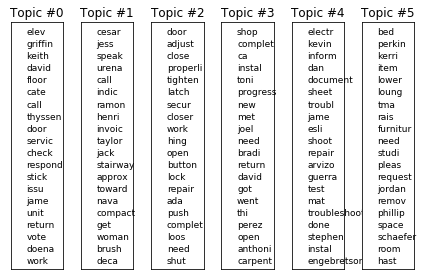

In [41]:
import warnings

warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
warnings.filterwarnings(action='ignore', category=UserWarning, module='depdoc')

import gensim
import matplotlib.pyplot as plt

Lda = gensim.models.ldamodel.LdaModel
model = lda

# Lsi = gensim.models.lsimodel.LsiModel
# model = Lsi.load('lsimodel.lda')

fontsize_base = 9
start_topic = 0
num_topics = 6
num_top_words = 20

topics_result = []
for x in range(start_topic,num_topics):
    topics_result.append(model.show_topic(x, topn=num_top_words))

for t in range(num_topics-start_topic):
    plt.subplot(1, num_topics-start_topic, t + 1)
    plt.ylim(0, num_top_words + 0.5)
    plt.xticks([])
    plt.yticks([])
    plt.title('Topic #{}'.format(start_topic+t))
    i = 0
    for word, share in topics_result[t]:
            plt.text(0.3, num_top_words - i - 0.5, word, fontsize=fontsize_base)
            i += 1

plt.tight_layout()
plt.show()

In [39]:
lda.get_document_topics(doc_term_matrix[50])

[(25, 0.18453996044233598),
 (30, 0.05379784253462698),
 (38, 0.10790549197366713),
 (60, 0.11152071838568857),
 (62, 0.240770836193861),
 (68, 0.078942288346104561),
 (86, 0.17357549370266273)]

In [40]:
lda.get_topic_terms(0,20)

[(674, 0.12700762064080626),
 (9713, 0.092162967740231319),
 (2227, 0.085795207813798083),
 (237, 0.064152096046815363),
 (50, 0.061450220638560003),
 (9788, 0.050760070579973601),
 (84, 0.033501704296103059),
 (1234, 0.028367974224030697),
 (17, 0.019465601571591596),
 (226, 0.018966696206418839),
 (104, 0.017756495414079879),
 (74, 0.01765676091030428),
 (279, 0.015080232724171527),
 (166, 0.014133485324214181),
 (1724, 0.013438500532715822),
 (738, 0.011912027066425692),
 (423, 0.011689924273151806),
 (4884, 0.011663712046918788),
 (4885, 0.011622320442767592),
 (63, 0.011138248918977165)]

In [41]:
lda_docs[50]

array(['holguin', 'pete', 'quit', 'stick', 'mention', 'joe', 'director',
       'lock', 'lot', 'servic', 'morn', 'thi', 'clean', 'ok', 'check',
       'offic', 'pleas', 'door'],
      dtype='<U43')

In [42]:
dictionary[9788]

'cate'

In [43]:
all_docs_topics = []
import operator
for doc in doc_term_matrix:
    topics = lda.get_document_topics(doc)
    topics.sort(key=operator.itemgetter(1),reverse=True)
    if len(topics)>0:
        doc_topics = "Topic " + str(topics[0][0]+1)
        row = 1
        while row<len(topics) and topics[0][1]-topics[row][1]<=0.1:
            doc_topics += ",Topic " + str(topics[row][0]+1)
            row += 1
    else:
        doc_topics = "None"
    all_docs_topics.append(doc_topics)

In [44]:
print(len(all_docs_topics))
print(len(df))

268526
268526


In [45]:
df['Topics'] = all_docs_topics

In [63]:
df = df.applymap(lambda x: x.encode('unicode_escape').
                 decode('utf-8') if isinstance(x, str) else x)

In [198]:
writer = pd.ExcelWriter('Facility_Report_with_Topics.xlsx')
df.to_excel(writer,'Sheet1')
writer.save()

In [46]:
count = 0
for doc in all_docs_topics:
    if len(doc) < 10:
        count += 1
print(count)

181796


In [47]:
df.iloc[0]['Total'] == 0

True

In [51]:
topic_cost = {}
topic_date = {}
for row in range(len(df)):
    cost = df.iloc[row]['Total']
    date_finished = df.iloc[row]['Date Finished']
    topic = df.iloc[row]['Topics']
    if len(topic) < 10 and date_finished != '- -' and cost != 0:
        if topic not in list(topic_cost):
            topic_cost[topic] = [cost]
            topic_date[topic] = [date_finished]
        else:
            topic_cost[topic].append(cost)
            topic_date[topic].append(date_finished)

In [52]:
for i in range(len(topic_cost)):
    topic = "Topic " + str(i)
    if topic not in list(topic_cost):
        print("N/A: Topic " + str(i))
    else:
        if len(topic_cost[topic]) != len(topic_date[topic]):
            print("Error: Topic " + str(i) )

N/A: Topic 0


In [75]:
len(df)

268526

In [48]:
new_df = df[df['Date Finished']!='- -']
new_df = new_df[new_df['Total']!=0]

In [49]:
new_df = new_df.sort_values('Date Finished')

In [50]:
print(len(new_df[new_df['Topics'] == 'Topic 1']))
print(len(topic_cost['Topic 1']))

82


NameError: name 'topic_cost' is not defined

In [ ]:
print(len(topic_cost))
print(len(topic_date))
print(len(new_df))

In [51]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Scatter, Figure, Layout
init_notebook_mode(connected=True)

In [52]:
topic = 86
topic = "Topic " + str(topic)
trace0 = Scatter(
    x = new_df[new_df['Topics'] == topic]['Date Finished'],
    y = new_df[new_df['Topics'] == topic]['Total'],
    mode = 'line',
    name = 'markers'
)

layout = Layout(xaxis = dict(title = 'Date Finished'), yaxis = dict(title = 'Total Cost'), title = topic + ': Date Finished v/s Total Cost')
data = [trace0]

fig = {'data' : data, 'layout' : layout}

iplot(fig)
plot(fig,  filename='topic.html')

'file://C:\\Users\\garvi\\PycharmProjects\\NEPTUNE_Facility_Reports\\topic.html'

In [69]:
temp = new_df[new_df['Topics'] == topic].groupby('Date Finished')

In [97]:
temp = pd.DataFrame(columns=['Topics'])

In [98]:
temp['Topics'] = new_df['Topics']

In [100]:
temp['Date Finished'] = new_df['Date Finished']

In [103]:
temp['Cost'] = new_df['Total']

In [73]:
len(new_df[new_df['Topics'] == topic]['Date Finished'])

1403

In [102]:
new_df.head()

,Work Order,WO Type,Charge Type,Reference Number,Project,Action Requested,Priority,Status,Requestor,Req Phone,...,Flat Bill,Warehouse Parts,NonStock Received and Invoiced,NonStock Received Not Invoiced,NonStock On Order Not Received,Total,Assigned Trades,General Comments,Task Comments,Topics
232735,POLY-115464,1 Corrective Maintenance,NaN,Bingham #9085,NaN,"Frank, please repair the 9085 Case loader with...",3 - 3 - Routine,Completed,Jesse Deanda,[4803277081],...,0.0,0.0,1183.35,0.0,0.0,1650.55,PMG05,12/9/16 and 2/8/17 - Frank replaced the tie ro...,NaN,Topic 70
234952,POLY-113247,1 Corrective Maintenance,NaN,NaN,NaN,Request for Frank to purchase mulching blades ...,3 - 3 - Routine,Finished,Frank Calderon Jr,[-4806621909],...,0.0,0.0,80.08,0.0,0.0,80.08,PMG05,NaN,NaN,"Topic 37,Topic 18,Topic 50"
140659,TMPE-109355,1 Corrective Maintenance,NaN,NaN,NaN,"INTDS B 353A: patch and paint the 6"" x 6"" sq...",4 - 4 - Scheduled,Completed,Jamie Larue,[-4807276928],...,0.0,0.0,0.00,0.0,0.0,139.65,T1MG1S1,NaN,NaN,"Topic 60,Topic 41"
197931,RFMT-110398,1 Corrective Maintenance,NaN,NaN,NaN,!! Repeat Request. ASU HD ServiceNow TASK#: T...,2 - 2 - Urgent,Completed,Arianna Moreno,[480-390-8688],...,0.0,0.0,0.00,0.0,0.0,46.55,RFMT1S2,NaN,2015-11-02 - 13160 - Russell Peterson-CAR exp...,"Topic 84,Topic 69"
149324,TMPE-100680,5 Service Request,NaN,11139,100023 - CPMG 11139: BYOH Princeton Space Reno...,I am requesting a FACMAN Project # and SWO#’s ...,5 - 5 - Deferred,Completed,Marion Singleton,[480-965-6032],...,0.0,0.0,349.24,0.0,0.0,791.47,T1MG3,NaN,2015-07-20 - 11000 - Rodger Johnson-key up and...,Topic 26


In [104]:
temp.head()

,Topics,Date Finished,Cost
232735,Topic 70,1934-01-03 00:00:00,1650.55
234952,"Topic 37,Topic 18,Topic 50",1980-09-08 00:00:00,80.08
140659,"Topic 60,Topic 41",2009-08-31 00:00:00,139.65
197931,"Topic 84,Topic 69",2013-10-23 00:00:00,46.55
149324,Topic 26,2014-08-30 00:00:00,791.47


In [106]:
temp_2 = temp[temp['Topics'] == 'Topic 86']

In [198]:
month_dict = {}
for index in range(len(temp_2)):
    row = temp_2.iloc[index]
    
    date = str(temp_2.iloc[index]['Date Finished'].date())
    date = date[:4] + '-' + date[5:7]
    if date in list(month_dict):
        month_dict[date] += row['Cost']
    else:
        month_dict[date] = row['Cost']

In [199]:
month_dict

{'2015-06': 101.38,
 '2015-07': 1056.77,
 '2015-08': 1030.5599999999999,
 '2015-09': 3178.0300000000007,
 '2015-10': 1998.6799999999998,
 '2015-11': 3273.4800000000014,
 '2015-12': 2112.5699999999993,
 '2016-01': 2782.1800000000003,
 '2016-02': 3966.8500000000017,
 '2016-03': 4219.2200000000039,
 '2016-04': 4795.1100000000015,
 '2016-05': 1736.1099999999999,
 '2016-06': 2419.4100000000003,
 '2016-07': 1775.9099999999999,
 '2016-08': 5016.7600000000002,
 '2016-09': 3267.889999999999,
 '2016-10': 5147.3499999999958,
 '2016-11': 4992.859999999996,
 '2016-12': 1614.8699999999997,
 '2017-01': 2868.2299999999977,
 '2017-02': 5670.3899999999967,
 '2017-03': 5370.4599999999973,
 '2017-04': 5123.3800000000001,
 '2017-05': 1624.1399999999999}

In [203]:
import plotly.graph_objs as go
topic = 86
topic = "Topic " + str(topic)
trace0 = go.Bar(
    x = list(month_dict),
    y = [month_dict[key] for key in list(month_dict)]
)

trace1 = Scatter(
    x = list(month_dict),
    y = [month_dict[key] for key in list(month_dict)],
    mode = 'line',
    name = 'markers'
)


layout = Layout(xaxis = dict(title = 'Date Finished'), yaxis = dict(title = 'Total Cost'), title = topic + ': Date Finished v/s Total Cost')
data = [trace1]

fig = {'data' : data, 'layout' : layout}

iplot(fig)
# plot(fig,  filename='topic.html')

In [204]:
temp_2 = temp[temp['Topics'] == 'Topic 86']

In [205]:
month_dict = {}
for index in range(len(temp_2)):
    row = temp_2.iloc[index]
    
    date = str(temp_2.iloc[index]['Date Finished'].date())
    date = date[:4] + '-' + date[5:7]
    if date in list(month_dict):
        month_dict[date] += 1
    else:
        month_dict[date] = 1

In [208]:
import plotly.graph_objs as go
topic = 86
topic = "Topic " + str(topic)
trace0 = go.Bar(
    x = list(month_dict),
    y = [month_dict[key] for key in list(month_dict)]
)

trace1 = Scatter(
    x = list(month_dict),
    y = [month_dict[key] for key in list(month_dict)],
    mode = 'line',
    name = 'markers'
)


layout = Layout(xaxis = dict(title = 'Date Finished'), yaxis = dict(title = 'Total Cost'), title = topic + ': Date Finished v/s Total Cost')
data = [trace1]

fig = {'data' : data, 'layout' : layout}

iplot(fig)
# plot(fig,  filename='topic.html')

In [53]:
len(new_df[new_df['Topics'] == topic]['Building'].unique())

155

In [54]:
buildings = new_df['Building'].unique()
topic = 86
topic = "Topic " + str(topic)
plot_df = new_df[new_df['Topics'] == topic]

data = []
for building in buildings:
    data.append(Scatter(
        x = plot_df[plot_df['Building'] == building]['Date Finished'],
        y = plot_df[plot_df['Building'] == building]['Total'],
        mode = 'line',
        name = building
    ))

layout = Layout(xaxis = dict(title = 'Date Finished'), yaxis = dict(title = 'Total Cost'), title = topic + ': Date Finished v/s Total Cost (per Building)')
# data = [trace0]

fig = {'data' : data, 'layout' : layout}

iplot(fig)
plot(fig,  filename='building.html')

'file://C:\\Users\\garvi\\PycharmProjects\\NEPTUNE_Facility_Reports\\building.html'

In [55]:
campuses = new_df['Campus'].unique()
topic = 86
topic = "Topic " + str(topic)
plot_df = new_df[new_df['Topics'] == topic]

data = []
for campus in campuses:
    data.append(Scatter(
        x = plot_df[plot_df['Campus'] == campus]['Date Finished'],
        y = plot_df[plot_df['Campus'] == campus]['Total'],
        mode = 'line',
        name = campus
    ))

layout = Layout(xaxis = dict(title = 'Date Finished'), yaxis = dict(title = 'Total Cost'), title = topic + ': Date Finished v/s Total Cost (per Campus)')
# data = [trace0]

fig = {'data' : data, 'layout' : layout}

iplot(fig)
plot(fig,  filename='campus.html')

'file://C:\\Users\\garvi\\PycharmProjects\\NEPTUNE_Facility_Reports\\campus.html'

In [224]:
campuses = new_df['Campus'].unique()
topic = 86
topic = "Topic " + str(topic)
plot_df = new_df[new_df['Topics'] == topic]

data = []
for campus in campuses:
    temp_df = plot_df[plot_df['Campus'] == campus]
    
    month_dict_campus = {}
    for index in range(len(temp_df)):
        row = temp_df.iloc[index]

        date = str(temp_df.iloc[index]['Date Finished'].date())
        date = date[:4] + '-' + date[5:7]
        if date in list(month_dict_campus):
            month_dict_campus[date] += row['Total']
        else:
            month_dict_campus[date] = row['Total']
        
    
    data.append(Scatter(
        x = list(month_dict_campus),
        y = [month_dict_campus[key] for key in list(month_dict_campus)],
        mode = 'line',
        name = campus
    ))

layout = Layout(xaxis = dict(title = 'Date Finished'), yaxis = dict(title = 'Total Cost'), title = topic + ': Date Finished v/s Total Cost (per Campus)')
# data = [trace0]

fig = {'data' : data, 'layout' : layout}

iplot(fig)
plot(fig,  filename='campus.html')

'file://C:\\Users\\garvi\\PycharmProjects\\NEPTUNE_Facility_Reports\\campus.html'

In [56]:
leed_df = pd.read_excel('ASU_LEED_Bldgs.xlsx')

In [57]:
leed_buildings = leed_df['Building Name'].unique()
buildings = new_df['Building'].unique()

In [58]:
buildings

array(['E757 - FACILITIES MANAGEMENT 1', '003 - INTERDISCIPLINARY B',
       '051F (CB) - PALO VERDE EAST (F)',
       'R10C (CB) - ORCHIDHOUSE AT THE BRICKYARD',
       '179 (CM) - CENTERPOINT BLDG. A', '006A - FARMER EDUCATION BLDG.',
       '095E - TEMPE CENTER ANNEX',
       '057H - BATEMAN PHYSICAL SCIENCES CENTER H',
       '108 (CM) - INTERDISCIPLINARY SCIENCE AND TECHNOLOGY BUILDING I',
       '039 (CB) - BOOKSTORE', '015 - CENTRAL PLANT - 015',
       '057F - BATEMAN PHYSICAL SCIENCES CENTER F',
       'P02 (CB) - TYLER STREET PARKING STRUCTURE (McALLISTER & TYLER)',
       '059B (CS) - CARSON STUDENT ATHLETE CENTER',
       '153 (CB) - FARRINGTON SOFTBALL STADIUM',
       '142 (CB) - UNIVERSITY TOWERS',
       '158 (CB) - SUN DEVIL SPORTS PERFORMANCE',
       '175 (CB) - VERDE DICKEY DOME',
       '041 - PHYSICAL EDUCATION BLDG. EAST', '021 - MURDOCK LECTURE HALL',
       '137 (CB) - CENTRAL PLANT SOUTH',
       '056E - LIFE SCIENCES TOWER E-WING',
       '056C - LIFE SCIENCE

In [59]:
leed_buildings

array(['Interdisciplinary Science & Technology Bldg II',
       'Interdisciplinary Science & Technology Bldg II Support',
       'Interdisciplinary Science & Technology Bldg III',
       'Biodesign Institute B', 'Biodesign Institute A', 'Fulton Center',
       'Interdisciplinary Science & Technology Bldg I',
       '2nd Floor Memorial Union Restoration', 'Applied Arts Pavilion',
       'Peralta Hall', 'Picacho Hall', 'Santa Catalina Hall',
       'Santan Hall', 'Wrigley Hall', 'Cronkite/Eight Building',
       'Acacia Hall', 'Acourtia Hall', 'Arroyo Hall', 'Chuparosa Hall',
       'Jojoba Hall', 'Mesquite Hall', 'Mohave Hall', 'Verbana Hall',
       'Arizona Biomedical Collaborative',
       'ASU Scottsdale Innovation Center Building 1',
       'ASU Police Department Facility',
       'Nursing and Healthcare Innovation Phase II', 'Agave Hall',
       'Cereus Hall', 'Cottonwood Hall', 'Honors Hall', 'Juniper Hall',
       'Sage Hall', 'Rosewood Hall', 'Willow Hall',
       'Weatherup Ce

In [60]:
for building in buildings:
    if "fitness".lower() in str(building).lower():
        print(building)

046 (CS) - SUN DEVIL FITNESS COMPLEX - 046
308 - SUN DEVIL FITNESS COMPLEX - 308
E831 - SUN DEVIL FITNESS COMPLEX - E831
915 - SUN DEVIL FITNESS COMPLEX - 915


In [61]:
leeds = ['054 (CM) - INTERDISCIPLINARY SCIENCE AND TECHNOLOGY BUILDING II',
'054A - INTERDISCIPLINARY SCIENCE AND TECHNOLOGY BLDG II SUPPORT',
'816 - INTERDISCIPLINARY SCIENCE AND TECHNOLOGY BUILDING III',
'104B (CM) - BIODESIGN INSTITUTE BLDG B',
'104A - BIODESIGN INSTITUTE BLDG A',
'R11 (CB) - FULTON CENTER',
'108 (CM) - INTERDISCIPLINARY SCIENCE AND TECHNOLOGY BUILDING I',
'035 (CB) - MEMORIAL UNION',
'E825A - PERALTA HALL',
'E827A - SANTA CATALINA HALL',
'E826 - SANTAN HALL',
'007 - WRIGLEY HALL',
'305 - CRONKITE/8',
'160E (CB) - HAV- ACACIA HALL',
'163C (CB) - HAV- ACOURTIA HALL',
'160B (CB) - HAV- ARROYO HALL',
'160D (CB) - HAV- CHUPAROSA HALL',
'160C (CB) - HAV- JOJOBA HALL',
'163A (CB) - HAV- MESQUITE HALL',
'160A (CB) - HAV- MOHAVE HALL',
'3001 - ARIZONA BIOMEDICAL COLLABORATIVE',
'E712 - FACILITIES MANAGEMENT / POLICE DEPARTMENT',
'173H (CB) - BARRETT COLLEGE HONORS HALL',
'173A (CB) - BARRETT COLLEGE SAGE HALL',
'173G (CB) - BARRETT COLLEGE WILLOW HALL',
'174 (CB) - WEATHERUP CENTER',
'075 (CM) - INTERDISCIPLINARY SCIENCE AND TECHNOLOGY BUILDING 4',
'914 - VERDE DINING PAVILION',
'040D - MCCORD HALL',
'025 (CS) - HEALTH SERVICE / 3004 - HEALTH SCIENCES EDUCATION BLDG.',
'E830 - CITRUS DINING PAVILION',
'061 (CB) - MANZANITA HALL',
'178 (CS) - COLLEGE AVENUE COMMONS',
'309 - BEUS CENTER FOR LAW AND SOCIETY',
'104C - BIODESIGN INSTITUTE BLDG C',
'917 - HERBERGER YOUNG SCHOLARS ACADEMY',
'059 (CB) - SUN DEVIL STADIUM',
'046 (CS) - SUN DEVIL FITNESS COMPLEX - 046',
'308 - SUN DEVIL FITNESS COMPLEX - 308',
'E831 - SUN DEVIL FITNESS COMPLEX - E831',
'915 - SUN DEVIL FITNESS COMPLEX - 915']

In [62]:
buildings = new_df['Building'].unique()
topic = 86
topic = "Topic " + str(topic)
plot_df = new_df[new_df['Topics'] == topic]

leed_data_df = plot_df[plot_df['Building'].isin(leeds)]
non_leed_data_df = plot_df[~plot_df['Building'].isin(leeds)]

trace0 = Scatter(
    x = leed_data_df['Date Finished'],
    y = leed_data_df['Total'],
    mode = 'line',
    name = 'LEED Certified Buildings'
)

trace1 = Scatter(
    x = non_leed_data_df['Date Finished'],
    y = non_leed_data_df['Total'],
    mode = 'line',
    name = 'Non-LEED Certified Buildings'
)

layout = Layout(xaxis = dict(title = 'Date Finished'), yaxis = dict(title = 'Total Cost'), title = topic + ': Date Finished v/s Total Cost (LEED)')
data = [trace0, trace1]

fig = {'data' : data, 'layout' : layout}

iplot(fig)
plot(fig,  filename='leeds.html')

'file://C:\\Users\\garvi\\PycharmProjects\\NEPTUNE_Facility_Reports\\leeds.html'

In [217]:
buildings = new_df['Building'].unique()
topic = 86
topic = "Topic " + str(topic)
plot_df = new_df[new_df['Topics'] == topic]

leed_data_df = plot_df[plot_df['Building'].isin(leeds)]
non_leed_data_df = plot_df[~plot_df['Building'].isin(leeds)]

month_dict_leed = {}
for index in range(len(leed_data_df)):
    row = leed_data_df.iloc[index]
    
    date = str(leed_data_df.iloc[index]['Date Finished'].date())
    date = date[:4] + '-' + date[5:7]
    if date in list(month_dict_leed):
        month_dict_leed[date] += row['Total']
    else:
        month_dict_leed[date] = row['Total']
        
        
month_dict_non_leed = {}
for index in range(len(non_leed_data_df)):
    row = non_leed_data_df.iloc[index]
    
    date = str(non_leed_data_df.iloc[index]['Date Finished'].date())
    date = date[:4] + '-' + date[5:7]
    if date in list(month_dict_non_leed):
        month_dict_non_leed[date] += row['Total']
    else:
        month_dict_non_leed[date] = row['Total']

trace0 = Scatter(
    x = list(month_dict_leed),
    y = [month_dict_leed[key] for key in list(month_dict_leed)],
    mode = 'line',
    name = 'LEED Certified Buildings'
)

trace1 = Scatter(
    x = list(month_dict_non_leed),
    y = [month_dict_non_leed[key] for key in list(month_dict_non_leed)],
    mode = 'line',
    name = 'Non-LEED Certified Buildings'
)

layout = Layout(xaxis = dict(title = 'Date Finished'), yaxis = dict(title = 'Total Cost'), title = topic + ': Date Finished v/s Total Cost (LEED)')
data = [trace0, trace1]

fig = {'data' : data, 'layout' : layout}

iplot(fig)
plot(fig,  filename='leeds.html')

'file://C:\\Users\\garvi\\PycharmProjects\\NEPTUNE_Facility_Reports\\leeds.html'

In [65]:
leed_data_df['Building'].unique()

array(['046 (CS) - SUN DEVIL FITNESS COMPLEX - 046',
       '035 (CB) - MEMORIAL UNION', '178 (CS) - COLLEGE AVENUE COMMONS',
       '104A - BIODESIGN INSTITUTE BLDG A',
       '104B (CM) - BIODESIGN INSTITUTE BLDG B',
       '308 - SUN DEVIL FITNESS COMPLEX - 308',
       '075 (CM) - INTERDISCIPLINARY SCIENCE AND TECHNOLOGY BUILDING 4',
       '054 (CM) - INTERDISCIPLINARY SCIENCE AND TECHNOLOGY BUILDING II',
       '040D - MCCORD HALL', '160B (CB) - HAV- ARROYO HALL',
       '305 - CRONKITE/8', '061 (CB) - MANZANITA HALL',
       '007 - WRIGLEY HALL', '160A (CB) - HAV- MOHAVE HALL',
       '163C (CB) - HAV- ACOURTIA HALL', '914 - VERDE DINING PAVILION',
       '915 - SUN DEVIL FITNESS COMPLEX - 915',
       '160C (CB) - HAV- JOJOBA HALL', '160E (CB) - HAV- ACACIA HALL',
       '160D (CB) - HAV- CHUPAROSA HALL', '163A (CB) - HAV- MESQUITE HALL'], dtype=object)

In [66]:
non_leed_data_df['Building'].unique()

array(['048 - NELSON FINE ARTS CENTER', '010 - HAYDEN LIBRARY',
       '152C - MERCADO C', '142 (CB) - UNIVERSITY TOWERS',
       '301 - UNIVERSITY CENTER - 301',
       '059B (CS) - CARSON STUDENT ATHLETE CENTER',
       '063 - ENGINEERING RESEARCH CENTER', '003 - INTERDISCIPLINARY B',
       '085 - GOLDWATER CENTER FOR SCIENCE & ENGINEERING',
       '056E - LIFE SCIENCES TOWER E-WING', '087 - ART BLDG.',
       '127 - DESIGN NORTH', '049 - WEST HALL',
       '023B - TOWER CENTER BUILDING B (WEST)',
       '011 (CB) - UNIVERSITY CLUB', '084 - MUSIC BLDG.',
       '069 (CS) - WELLS FARGO ARENA', '043 - ARMSTRONG HALL',
       '307 - HEALTH NORTH', '930B - LAS CASAS - B WING (NE)',
       '026C (CB) - IRISH HALL C (SOUTHWEST)',
       '912 - NORTH SERVICES BUILDING', '152D - MERCADO D',
       '053B - ENGINEERING CENTER B', '143 - ROSS-BLAKLEY HALL',
       '041 - PHYSICAL EDUCATION BLDG. EAST', '900 - FLETCHER LIBRARY',
       '047 - NOBLE SCIENCE LIBRARY',
       'R41 (CB) - ASU PERFO

In [118]:
new_df = new_df.applymap(lambda x: x.encode('unicode_escape').
                 decode('utf-8') if isinstance(x, str) else x)

In [119]:
X = 
Y = list(new_df[new_df['Topics'] == "Topic 2"]['Total'])
p1 = np.polyfit(X,Y,1) 
p2 = np.polyfit(X,Y,2) 
p3 = np.polyfit(X,Y,3) 
plt.figure(figsize=(18, 8))
plot(X,Y,'o')
plot(X,polyval(p1,X),'r-')
plot(X,polyval(p2,X),'b-')
plot(X,polyval(p3,X),'g-')

TypeError: ufunc 'add' did not contain a loop with signature matching types dtype('<U32') dtype('<U32') dtype('<U32')